# Traveltime tomography using the Eikonal equation (2D case)

@Author: Ettore Biondi - ebiondi@caltech.edu


First create a conda env as:

`conda create --name Eikonal python==3.9`

Then run the notebook within that environment after the installation steps below.

To use this notebook, we need pykonal installed. In your env, you can install it by:
1. `conda install cython`
2. `pip install occamypy`
3. `pip install numpy==1.22.4 dask==2022.8.1 dask-jobqueue==0.7.3`
4. `pip install git+https://github.com/malcolmw/pykonal@0.2.3b3`
5. `pip install pyLops`

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import numpy as np
import occamypy as o
import eikonal2d as k
from utilities3 import*
import torch
import torch.nn as nn
import torch.nn.functional as F
# from FNO import *

In [35]:
import numpy as np
import occamypy as o
import eikonal2d as k

# Plotting
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
rcParams.update({
    'image.cmap'     : 'jet_r',
    'image.aspect'   : 'auto',
    'axes.grid'      : False,
    'figure.figsize' : (10, 6),
    'savefig.dpi'    : 300,
    'axes.labelsize' : 14,
    'axes.titlesize' : 16,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})

In [36]:
# Velocity field
dx = dz = 0.1
nx, nz = 100, 100
x = np.linspace(0,(nx-1)*dx, nx)
z = np.linspace(0,(nz-1)*dz, nz)

# Velocity model
vv = o.VectorNumpy((nx,nz), ax_info=[o.AxInfo(nx, 0, dx, "x [km]"), o.AxInfo(nz, 0, dz, "z [km]")])
vv[:] = 1. + 0.1*z

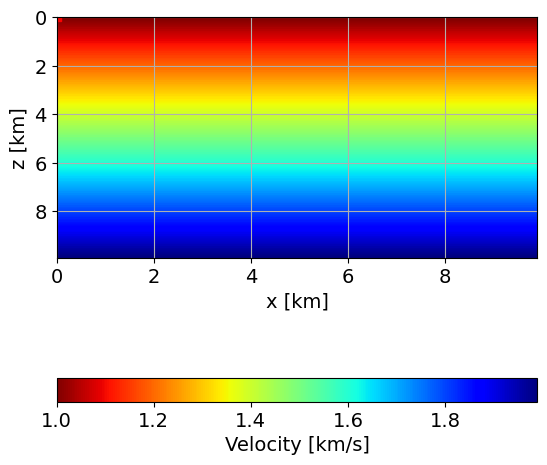

In [37]:
fig, ax = plt.subplots()
im = ax.imshow(vv.plot().T, extent=[x[0], x[-1], z[-1], z[0]], aspect=0.5)
ax = plt.gca()
ax.grid()
plt.xlabel(vv.ax_info[0].l)
plt.ylabel(vv.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0))
cbar.set_label('Velocity [km/s]')
plt.tight_layout()
ax.plot(0, 0,'rs') 
plt.show()

In [46]:
# Source/Receiver positions
SouPos = np.array([[50, nz-1]])
# SouPos = np.array([[0, int((nz-1)/2)]])
RecPos = np.array([[ix,5] for ix in np.arange(0,nx)])
print(int(nx/2))

# Data vector
tt_data = o.VectorNumpy((SouPos.shape[0], RecPos.shape[0]),
                        ax_info=[o.AxInfo(SouPos.shape[0], 0, 1, "rec_id"), vv.ax_info[0]])
tt_data.zero()

# Setting Forward non-linear operator
Eik2D_Op = k.EikonalTT_2D(vv, tt_data, SouPos, RecPos)
Eik2D_Op.forward(False, vv, tt_data)

50


ValueError: Buffer dtype mismatch, expected 'Py_ssize_t' but got 'long'

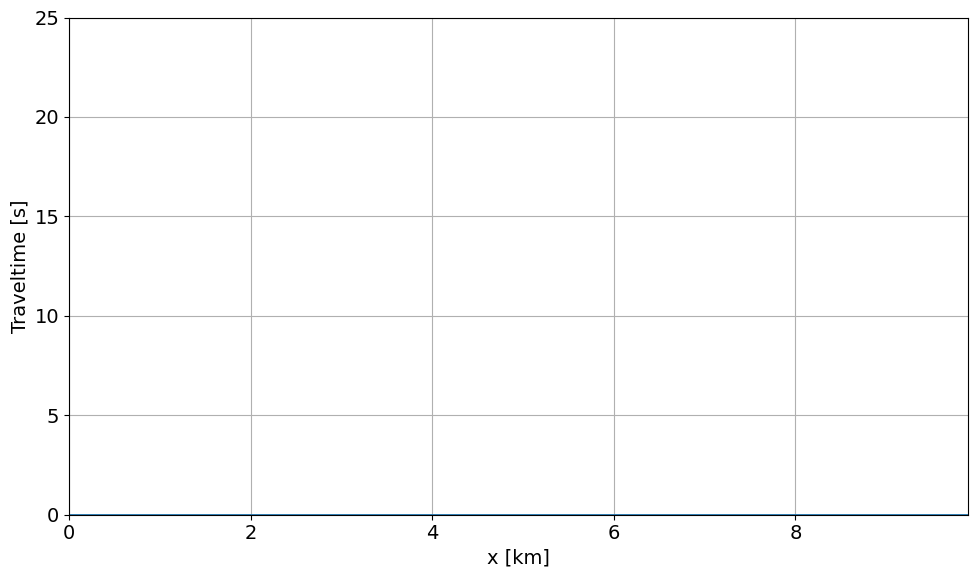

In [ ]:
# Plotting traveltime vector
fig, ax = plt.subplots()
ax.plot(tt_data.ax_info[1].plot(), tt_data[0], lw=2)
ax.grid()
plt.xlabel(tt_data.ax_info[1].l)
plt.ylabel("Traveltime [s]")
ax.set_ylim(0, 25)
ax.set_xlim(tt_data.ax_info[1].o, tt_data.ax_info[1].last)
plt.tight_layout()
plt.show()

In [44]:
# Dot-product test for the linearized Eikonal equation in 1D
# can compute df/dv
Eik2D_Lin_Op = k.EikonalTT_lin_2D(vv, tt_data, SouPos, RecPos)
# Eik2D_Lin_Op.dotTest(True)

## Sensitivity kernel

Let's compute the sensitivity kernel for a given source using the linearized Eikonal operator.

In [45]:
tt_pert = tt_data.clone().set(.5)
kernel = vv.clone()
# Computing the kernel
Eik2D_Lin_Op.adjoint(False, kernel, tt_pert)

ValueError: Buffer dtype mismatch, expected 'Py_ssize_t' but got 'long'

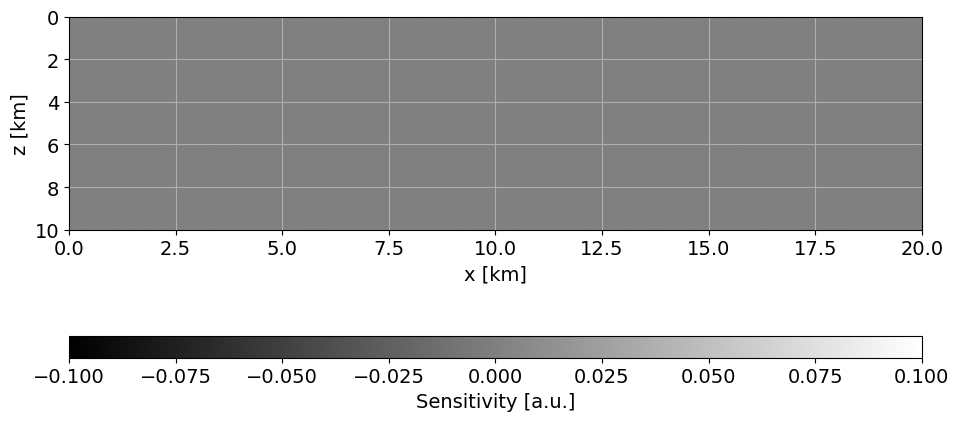

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(kernel.plot().T, extent=[x[0], x[-1], z[-1], z[0]], aspect=0.5, cmap=plt.get_cmap("gray"), vmin=kernel.min()*0.1, vmax=kernel.max())
ax = plt.gca()
ax.grid()
plt.xlabel(kernel.ax_info[0].l)
plt.ylabel(kernel.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0))
cbar.set_label('Sensitivity [a.u.]')
plt.tight_layout()
plt.show()

## Inversion

In [ ]:
# Fast-Marching-Method (FMM)
# dx = dz = 0.05
dx = dz = 0.1
nx, nz = 100, 100
x = np.linspace(0,(nx-1)*dx, nx)
z = np.linspace(0,(nz-1)*dz, nz)

# Background Velocity model
vv0 = o.VectorNumpy((nx,nz), ax_info=[o.AxInfo(nx, 0, dx, "x [km]"), o.AxInfo(nz, 0, dz, "z [km]")])
vv0[:] = 1.0 + z*0.1

# Gaussian anomaly
zz, xx = np.meshgrid(z, x)
dst = np.sqrt(xx*xx+zz*zz)
sigma = 1.0
xloc = 50*dx
zloc = 50*dz
gauss = np.exp(-( ((xx-xloc)**2 + (zz-zloc)**2) / (2.0*sigma**2)))
# Constructing true model
vv = vv0.clone()
vv[:] -= gauss*0.5

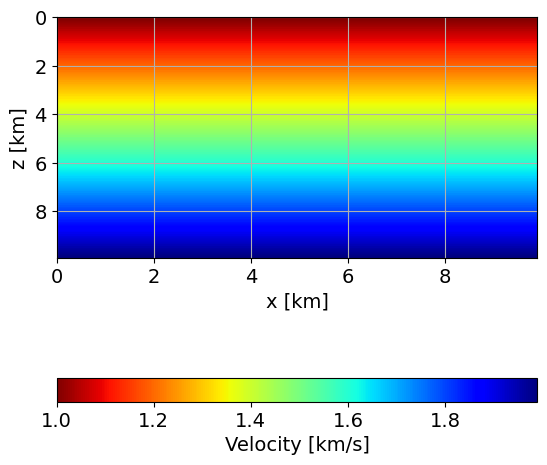

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(vv0.plot().T, extent=[x[0], x[-1], z[-1], z[0]], aspect=0.5)
ax = plt.gca()
ax.grid()
plt.xlabel(vv0.ax_info[0].l)
plt.ylabel(vv0.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0))
cbar.set_label('Velocity [km/s]')
plt.tight_layout()
plt.show()

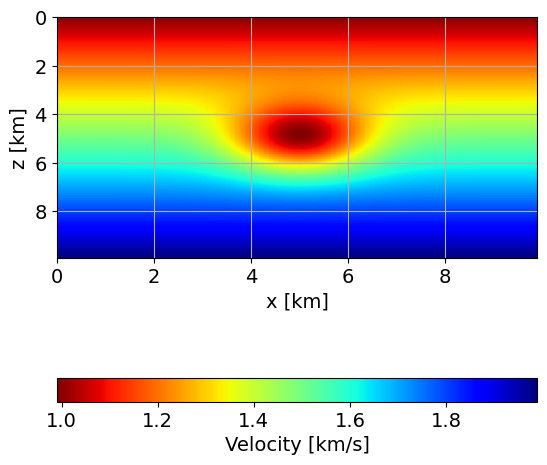

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(vv.plot().T, extent=[x[0], x[-1], z[-1], z[0]], aspect=0.5)
ax = plt.gca()
ax.grid()
plt.xlabel(vv.ax_info[0].l)
plt.ylabel(vv.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0))
cbar.set_label('Velocity [km/s]')
plt.tight_layout()
plt.show()

In [ ]:
# Source/Receiver positions
SouPos = np.array([[ix,nz-1] for ix in np.arange(0,nx,10)])
RecPos = np.array([[ix,0] for ix in np.arange(0,nx)])

# Data vector
tt_data = o.VectorNumpy((SouPos.shape[0], RecPos.shape[0]),
                        ax_info=[o.AxInfo(SouPos.shape[0], 0, 1, "rec_id"), vv.ax_info[0]])

# Instantiating non-linear operator
Eik2D_Op = EikonalTT_2D(vv, tt_data, SouPos, RecPos)
Eik2D_Lin_Op = EikonalTT_lin_2D(vv, tt_data, SouPos, RecPos, tt_maps=Eik2D_Op.tt_maps)
Eik2D_NlOp = o.NonlinearOperator(Eik2D_Op, Eik2D_Lin_Op, Eik2D_Lin_Op.set_vel)

In [ ]:
# Creating observed data
Eik2D_Op.forward(False, vv, tt_data)
tt_data_obs = tt_data.clone()

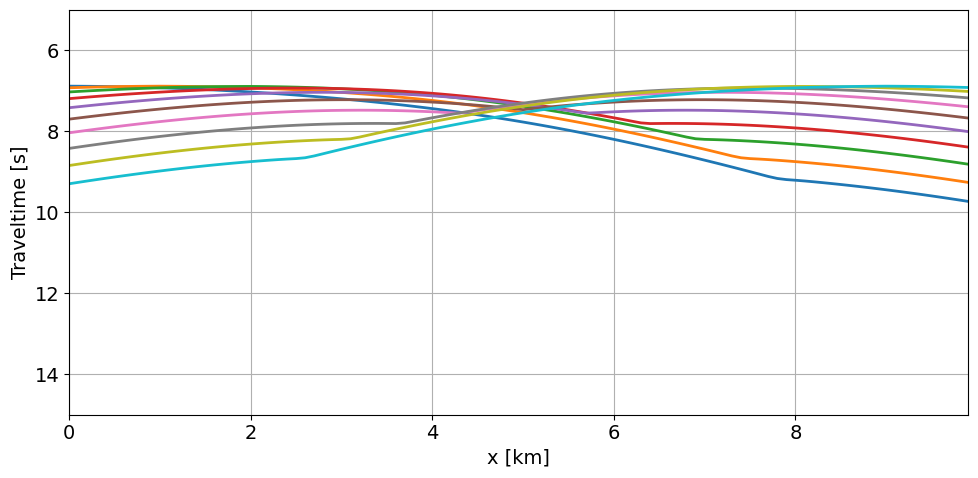

In [ ]:
# Plotting traveltime vector
fig, ax = plt.subplots(figsize=(10,5))
for ids in range(SouPos.shape[0]):
    ax.plot(tt_data.ax_info[1].plot(), tt_data[ids], lw=2)
ax.grid()
plt.xlabel(tt_data.ax_info[1].l)
plt.ylabel("Traveltime [s]")
ax.set_ylim(5.0, 15.0)
ax.set_xlim(tt_data.ax_info[1].o, tt_data.ax_info[1].last)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# instantiate solver
BFGSBsolver = o.LBFGS(o.BasicStopper(niter=25, tolg_proj=1e-32), m_steps=30)

# Creating problem object using Smoothing filter
G = o.GaussianFilter(vv0, 1.5)

Eik2D_Inv_NlOp = o.NonlinearOperator(Eik2D_Op, Eik2D_Lin_Op * G, Eik2D_Lin_Op.set_vel)

L2_tt_prob = o.NonlinearLeastSquares(vv0.clone(), tt_data_obs, Eik2D_Inv_NlOp,
                                     minBound=vv0.clone().set(1.),  # min velocity: 1 km/s
                                     maxBound=vv0.clone().set(2.5)) # max velocity: 2.5 km/s

In [ ]:
BFGSBsolver.run(L2_tt_prob, verbose=True)

##########################################################################################
            L-BFGS Solver 
    Max steps to invert the Hessian: 30 
    Restart folder: /tmp/restart_2023-11-06T22-30-20.100676/
    Problem: Nonlinear Least Squares
##########################################################################################

iter = 00, obj = 2.76e+01, rnorm = 7.43e+00, gnorm = 0.00e+00, feval = 001, geval = 01
Gradient vanishes identically
##########################################################################################
            L-BFGS Solver end
##########################################################################################



In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(L2_tt_prob.model.plot().T, extent=[x[0], x[-1], z[-1], z[0]], aspect=0.5)
ax = plt.gca()
ax.grid()
plt.xlabel(L2_tt_prob.model.ax_info[0].l)
plt.ylabel(L2_tt_prob.model.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal", label='Velocity [km/s]',
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0))
plt.tight_layout()
plt.show()